### Step 1: Importing Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

### Step 2: Loading the MNIST Data

In [2]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=ToTensor())

In [3]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=ToTensor())

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
# Let us see a sample data
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [12]:
# As you can see, the data consists of a tuple with the first element describing the image and the second element the corresponding label

image, label = train_data[0]
print('Shape:', image.shape, '\nLabel:', label)

Shape: torch.Size([1, 28, 28]) 
Label: 5


### Step 3: Viewing the Image

AxesImage(shape=(28, 28))


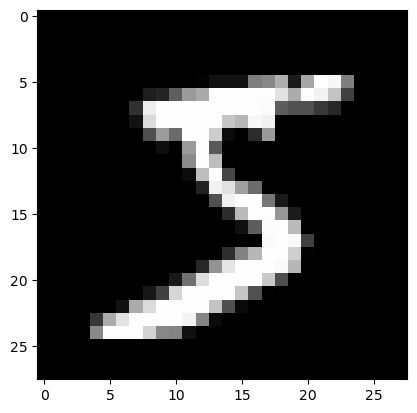

In [14]:
print(plt.imshow(train_data[0][0].squeeze(), cmap='gray'))

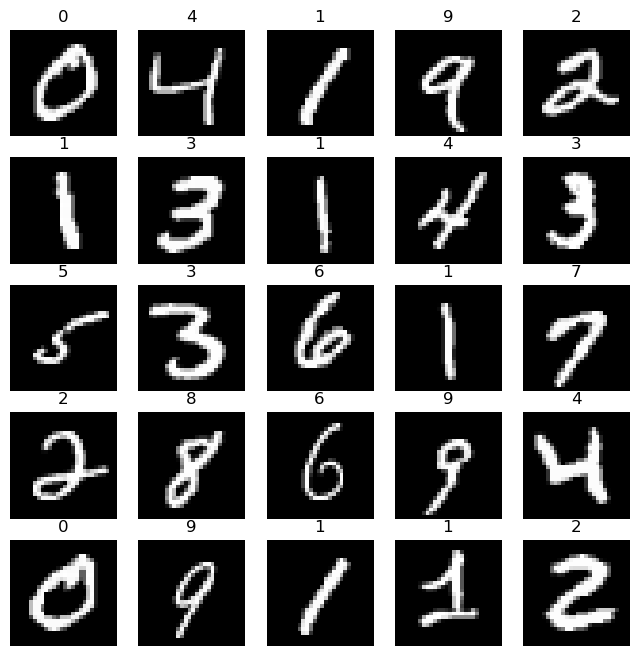

In [18]:
figure = plt.figure(figsize=(8,8))
rows, cols = 5, 5 
for i in range(1,26):
    image, label = train_data[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

### Step 4: Loading Batches With Dataloader

In [23]:
torch.manual_seed(100)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

###  Step 5: Viewing Batch of Images

Labels:  [   4    3    6    2    5    8    6    5    6    3]


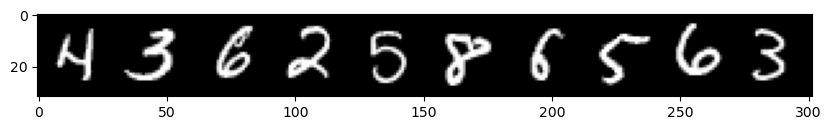

In [24]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in train_loader: 
    break

# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  # the default nrow is 8
plt.figure(figsize=(10,4))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Step 6: Defining the Convolutional Neural Network Class

In [45]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        # Setting up the convolutional layers
        self.conv1 = nn.Conv2d(1, 6, 3, 1) 
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Setting up the fully connected layers
        self.fc1 = nn.Linear(5*5*16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    # Now defining the forward propagation 
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        X = self.flatten(X)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)       

In [46]:
torch.manual_seed(100)

model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Step 7: Count the Model Parameters

In [47]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [48]:
count_parameters(model)

    54
     6
   864
    16
 51200
   128
  8192
    64
   640
    10
______
 61174


### Step 8: Defining the Loss Function and the Optimizer

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### Step 9: Training the Model

In [50]:
import time 

start_time = time.time()

epoch = 10
train_losses = []
train_correct = []
test_losses = []
test_correct = []

for i in range(epoch):
    trn_corr = 0
    tst_corr = 0

    # Running each training batch
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1

        # Running the model
        y_pred = model(X_train) # No need to flatten the image here as in the case of ANN, which is pretty nice 
        loss = criterion(y_pred, y_train)

        # Tallying the number of correct predictions 
        predicted = torch.max(y_pred.detach(), 1)[1]
        trn_corr += (predicted == y_train).sum()

        # Updating the parameters 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
            accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    # Updating the loss and train accuracy from each epoch
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Running the testing batches 
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Applying the model
            y_val = model(X_test)

            # Tallying the number of correct predictions
            predicted = torch.max(y_val.detach(), 1)[1]
            tst_corr += (predicted == y_test).sum()


    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  

epoch:  0  batch:  600 [  6000/60000]  loss: 0.21852629              accuracy:  78.817%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.09834445              accuracy:  86.575%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.01924497              accuracy:  89.756%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.23750611              accuracy:  91.379%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.01082456              accuracy:  92.497%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.03360935              accuracy:  93.136%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.04446172              accuracy:  93.676%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.02378612              accuracy:  94.135%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.04063389              accuracy:  94.489%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.09611981              accuracy:  94.817%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00146170              accuracy:  98.167%
epoch:  1  batch: 1200 [ 12000/6

### Step 10: Plotting the Loss and Accuracy Comparions

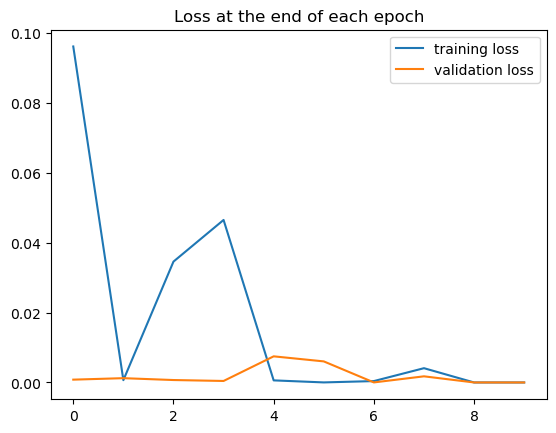

In [51]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

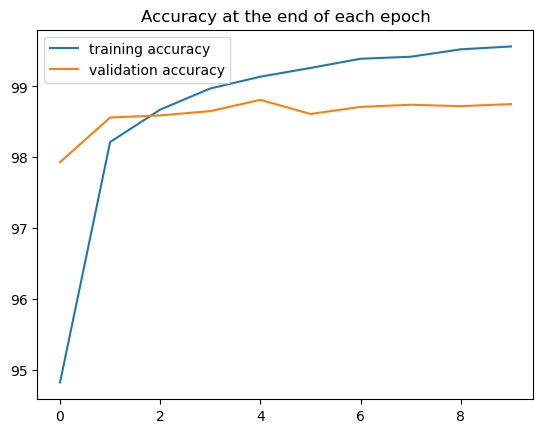

In [52]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Step 11: Evaluating Test Data

The test scores that we during for our training session:

In [54]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1]*100/10000:.3f}%') # print the most recent result as a percent

[9793, 9856, 9859, 9865, 9881, 9861, 9871, 9874, 9872, 9875]

Test accuracy: 98.750%


Now running the model for the whole testing dataset all at once:

In [56]:
test_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [58]:
with torch.no_grad():
    correct = 0 
    for X_test, y_test in test_all:
        y_val = model(X_test)
        predicted = torch.max(y_val.detach(), 1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%') 

Test accuracy: 9875/10000 =  98.750%


### Step 12: Evaluating the Confusion Matrix

In [60]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted, y_test))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 974    0    2    0    0    0    6    0    1    0]
 [   1 1127    0    0    0    0    3    3    0    0]
 [   0    2 1014    0    0    0    1    0    4    0]
 [   0    1    2 1004    0   12    0    0    5    2]
 [   1    1    0    0  976    0    5    0    2   11]
 [   0    2    0    0    0  878    3    0    1    2]
 [   1    0    0    0    3    2  939    0    1    0]
 [   0    2   14    5    1    0    0 1023    5    6]
 [   0    0    0    1    0    0    1    1  953    1]
 [   3    0    0    0    2    0    0    1    2  987]]


### Step 13: Examining the Misses

Now let us try to get the indices of the "missed" predictions to get a better idea of the kind of images our model underperformed in.

In [61]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

125

In [62]:
# Display the first 10 index positions
misses[:10]

array([   8,  340,  359,  445,  495,  543,  582,  625,  659,  674])

In [63]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [   8  340  359  445  495  543  582  625  659  674  839  882]
Label: [   5    5    9    6    8    8    8    6    2    5    8    9]
Guess: [   6    3    4    0    6    7    2    4    7    3    3    7]


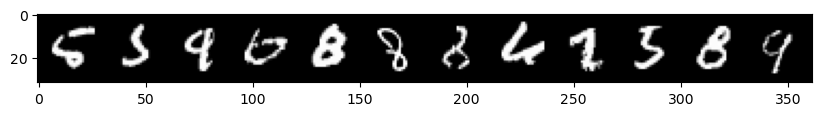

In [64]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Step 14: Testing the Model With a New Image

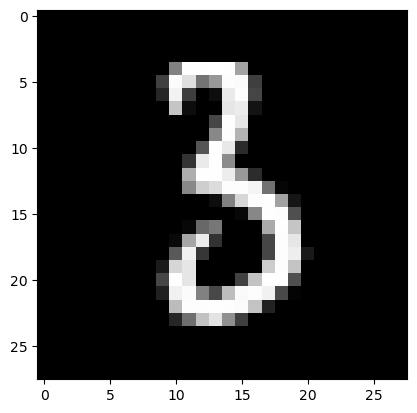

In [69]:
x = 2025
plt.imshow(test_data[x][0].squeeze(), cmap = 'gray')

In [82]:
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].unsqueeze(1)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 3
